In [101]:
import os
import bigframes.pandas as bf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bf.options.bigquery.project = 'credit-business-on-demand-9fd5'

In [3]:
query_tomado_kgiro = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.documento_kgiro_estudo_vencedores`"""
df_tomado_kgiro = bf.read_gbq(query_tomado_kgiro)
base_tomado_kgiro = df_tomado_kgiro.to_pandas()

In [4]:
base_tomado_kgiro['RootDocumentNumber'] = base_tomado_kgiro['RootDocumentNumber'].astype(int)

In [5]:
base_w = pd.read_csv('document_winners.csv')

In [6]:
base_w['RootDocumentNumber'] = base_w['document'].astype(str).str[:8].astype(int)

In [7]:
ls_document_w = base_w['RootDocumentNumber'].unique().tolist()

In [60]:
base_tomado_kgiro_w = base_tomado_kgiro[base_tomado_kgiro['RootDocumentNumber'].isin(ls_document_w)]

In [61]:
base_tomado_kgiro_w = base_tomado_kgiro_w.sort_values(by=['RootDocumentNumber', 'ReferenceMonth'])

In [62]:
base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .pct_change())
base_tomado_kgiro_w['diff_valorTomadoKGiro'] = (
    base_tomado_kgiro_w
    .groupby('RootDocumentNumber')['valorTomadoKGiro']
    .diff())

In [63]:
base_tomado_kgiro_w['check_var_pct_valorTomadoKGiro'] = np.where(
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'] > 0.1) &
    (~np.isinf(base_tomado_kgiro_w['var_pct_valorTomadoKGiro']) &
    (base_tomado_kgiro_w['var_pct_valorTomadoKGiro'].notna())),
    1, 0)

In [13]:
query_rosa_ventos = f""" SELECT * FROM `dataplatform-prd.credit_business_intelligence.vw_clientes_rosa_ventos`"""
df_rosa_ventos = bf.read_gbq(query_rosa_ventos)
base_rosa_ventos = df_rosa_ventos.to_pandas()

In [19]:
base_rosa_ventos['RootDocumentNumber'] = base_rosa_ventos['documento'].str[:8].astype(int)

In [21]:
base_rosa_ventos_w = base_rosa_ventos[base_rosa_ventos['RootDocumentNumber'].isin(ls_document_w)]

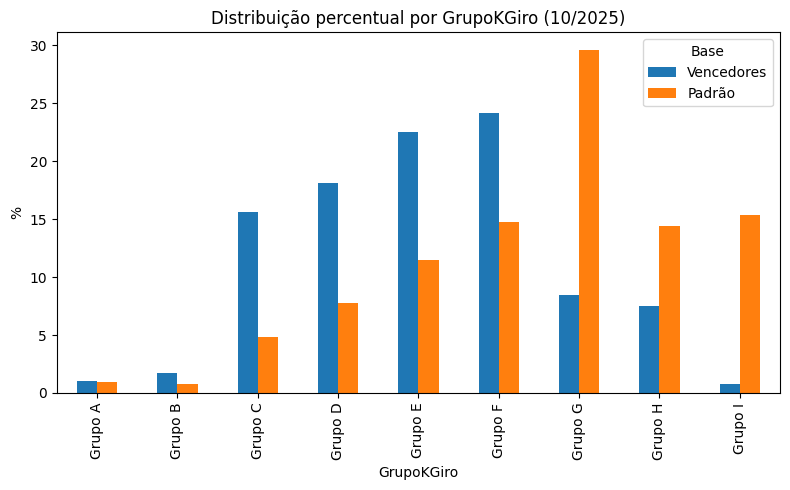

In [51]:
# Create value count percentages for both
df1 = base_rosa_ventos_w['GrupoKGiro'].value_counts(normalize=True) * 100
df2 = base_rosa_ventos['GrupoKGiro'].value_counts(normalize=True) * 100

# Combine them into one DataFrame
df_plot = pd.DataFrame({
    'Vencedores': df1,
    'Padrão': df2
}).fillna(0)  # fill missing categories with 0

# Plot grouped bars
df_plot.plot(kind='bar', figsize=(8,5))
plt.title('Distribuição percentual por GrupoKGiro (10/2025)')
plt.ylabel('%')
plt.xlabel('GrupoKGiro')
plt.legend(title='Base')
plt.tight_layout()
plt.show()

In [64]:
base_kgiro_rosas = base_tomado_kgiro_w.merge(base_rosa_ventos_w,how='left',on=['RootDocumentNumber']).dropna(subset=['GrupoKGiro'])

In [66]:
base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]['diff_valorTomadoKGiro'].sum()

1575004769.63

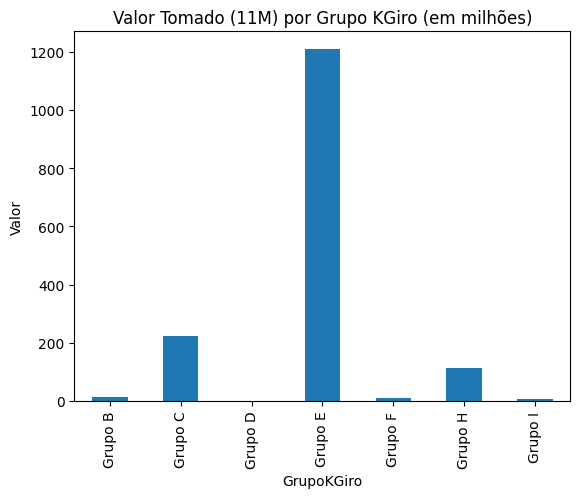

In [124]:
(
    base_kgiro_rosas[base_kgiro_rosas['check_var_pct_valorTomadoKGiro'] == 1]
    .groupby(['GrupoKGiro'])
    .agg(valor_tomado_KGiro=('diff_valorTomadoKGiro', 'sum'))
    .assign(valor_tomado_KGiro=lambda x: x['valor_tomado_KGiro'] / 1_000_000)
    .plot(kind='bar', legend=False)
)

plt.ylabel('Valor')
plt.title('Valor Tomado (11M) por Grupo KGiro (em milhões)')
plt.show()

In [74]:
query_eligibilidade = f""" SELECT * FROM `dataplatform-nonprd.credit_negocios.elegibilidade_estudo_vencedores`"""
df_eligibilidade = bf.read_gbq(query_eligibilidade)
base_eligibilidade = df_eligibilidade.to_pandas()

In [77]:
base_eligibilidade.sort_values(by=['document','created_at'],inplace=True)

In [87]:
base_eligibilidade_res = base_eligibilidade.groupby(['document']).last().reset_index()

In [89]:
base_eligibilidade_res['RootDocumentNumber'] = base_eligibilidade_res['document'].str[:8].astype(int)

In [92]:
base_eligibilidade_res_w = base_eligibilidade_res[base_eligibilidade_res['RootDocumentNumber'].isin(ls_document_w)]

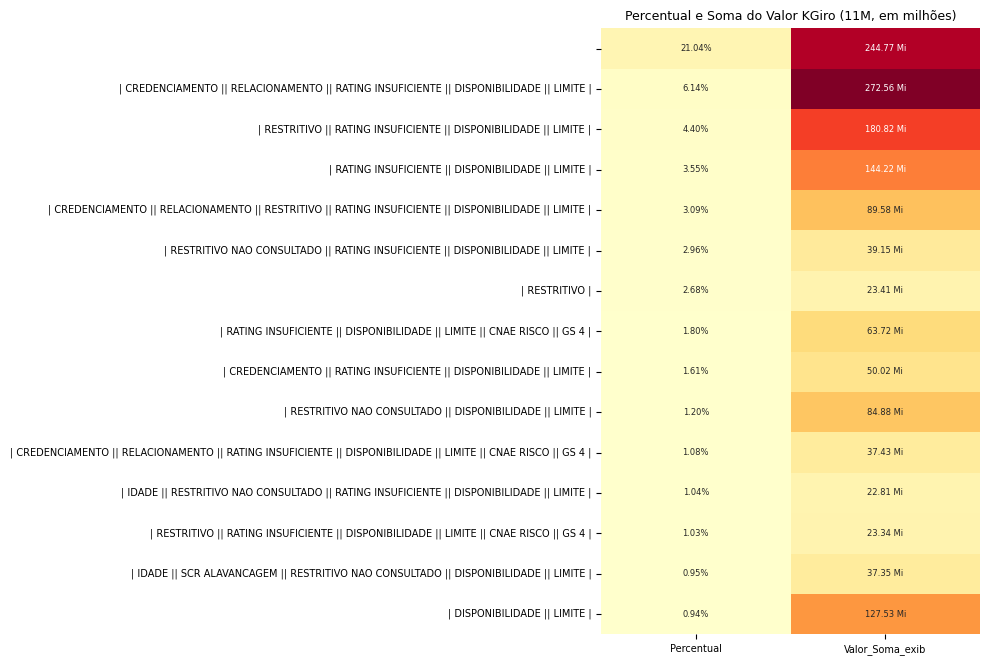

In [128]:
# ==========================
# 4) Heatmap-tabela: Razões x (Percentual, Soma)
# ==========================
data_plot = tabela[['Percentual', valor_col_plot]].copy()

# Garante que ambas as colunas são numéricas
for c in data_plot.columns:
    data_plot[c] = pd.to_numeric(data_plot[c], errors='coerce')

# (Opcional) se houver NaN, substitui por 0 para o heatmap
data_plot = data_plot.fillna(0.0)

# Labels personalizados por coluna (strings apenas para anotação)
labels = pd.DataFrame(index=data_plot.index, columns=data_plot.columns)
labels['Percentual'] = data_plot['Percentual'].map(lambda x: f"{x:.2f}%")

if SCALE_MILLIONS:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(lambda x: f"{x:.2f} Mi")
else:
    labels[valor_col_plot] = data_plot[valor_col_plot].map(
        lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    )

plt.figure(figsize=(10, max(6, TOP_N * 0.45)))

sns.heatmap(
    data_plot.astype(float),
    annot=labels.to_numpy(),
    fmt="",
    cmap='YlOrRd',
    cbar=False,               # remove a escala da cor
    yticklabels=data_plot.index,
    annot_kws={"size": 6},    # texto dentro das células menor
)

plt.title('Percentual e Soma do Valor KGiro (11M, em milhões)', fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()

